In [14]:
import os
import pandas as pd
import soundfile as sf 
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import accuracy_score
from google.colab import drive

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
VERBO = '/content/drive/MyDrive/VERBO_OK/'
dir_list = os.listdir(VERBO)
dir_list.pop(3)

'features'

In [8]:
emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(VERBO + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(part[0])
        temp = part[1]
        if temp == "f1" or temp =='f2' or temp == 'f3' or temp == 'f4' or temp == 'f5' or temp == 'f6':
            temp = "feminino"
        else:
            temp = "masculino"
        gender.append(temp)
        path.append(VERBO + i + '/' + f)

        
VERBO_df = pd.DataFrame(emotion)
VERBO_df = VERBO_df.replace({'neu':1, 'des':2, 'ale':3, 'tri':4, 'rai':5, 'med':6, 'sur':7})
VERBO_df = pd.concat([pd.DataFrame(gender),VERBO_df],axis=1)
VERBO_df.columns = ['gender','emotion']
#VERBO_df['labels'] = VERBO_df.gender + '_' + VERBO_df.emotion
VERBO_df['source'] = 'VERBO'  
VERBO_df = pd.concat([VERBO_df,pd.DataFrame(path, columns = ['path'])],axis=1)
#VERBO_df = VERBO_df.drop(['gender', 'emotion'], axis=1)
#VERBO_df.labels.value_counts()
VERBO_df.head(5)

,gender,emotion,source,path
0,feminino,2,VERBO,/content/drive/MyDrive/VERBO_OK/f3/des-f3-l1.wav
1,feminino,6,VERBO,/content/drive/MyDrive/VERBO_OK/f3/med-f3-l1.wav
2,feminino,1,VERBO,/content/drive/MyDrive/VERBO_OK/f3/neu-f3-ns4.wav
3,feminino,3,VERBO,/content/drive/MyDrive/VERBO_OK/f3/ale-f3-ns2.wav
4,feminino,3,VERBO,/content/drive/MyDrive/VERBO_OK/f3/ale-f3-ns1.wav


In [9]:

def audio_features_MFCC(file_title):
    with sf.SoundFile(file_title) as audio_recording:
        audio = audio_recording.read(dtype="float32")
        sample_rate = audio_recording.samplerate 
        result=np.array([])       
        mfccs=np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))    
    return result

In [15]:
def audio_features_Chroma(file_title):
    with sf.SoundFile(file_title) as audio_recording:
        audio = audio_recording.read(dtype="float32")
        sample_rate = audio_recording.samplerate 
        stft=np.abs(librosa.stft(audio))
        result=np.array([])
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
    return result

In [16]:
def audio_features_Mel(file_title):
    with sf.SoundFile(file_title) as audio_recording:
        audio = audio_recording.read(dtype="float32")
        sample_rate = audio_recording.samplerate 
        result=np.array([])
        mel=np.mean(librosa.feature.melspectrogram(audio, sr=sample_rate).T,axis=0)        
        result=np.hstack((result, mel))
    return result

In [49]:
def loading_audio_data():
    qtd = len(VERBO_df.path)
    x = []
    y = []

    for i in range(qtd):                       
        emotion = VERBO_df.emotion[i]
        path = VERBO_df.path[i]
        feature = audio_features_MFCC(path)
        #feature = audio_features_Chroma(path)
        #feature = audio_features_Mel(path)
        
        x.append(feature)   
        y.append(emotion)

    return {"X":x,"y":y}

In [50]:
import time
start_time = time.time()

dic_chroma = loading_audio_data()

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 24.072849988937378 seconds ---


In [51]:
X = pd.DataFrame(dic_chroma["X"])
y = pd.DataFrame(dic_chroma["y"])

In [52]:
data = pd.concat([X, y], axis =1)

In [53]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,0
0,-299.244476,134.937912,-38.547646,32.485504,3.204261,-26.618738,14.904951,-7.597967,-9.162752,4.662045,-11.622400,-3.855593,-6.554804,-13.773700,-2.608310,-7.527237,-4.670477,0.697392,-9.785432,-4.865035,-2.856929,-9.714797,-2.941893,-4.022176,-7.476486,-1.894922,-4.093746,-2.224765,2.169287,0.460872,6.342788,7.944646,4.955812,7.856286,4.108639,2.609336,4.280911,0.224271,3.728909,5.090572,2
1,-280.755219,126.081894,-41.298115,38.425438,0.828395,-24.939224,19.244261,-11.226633,-9.258340,3.081147,-17.815662,-2.693212,-3.222776,-11.625367,0.875252,-8.848180,-7.264411,1.203914,-10.972466,-5.013815,-2.063886,-11.895419,-3.339726,-3.934288,-8.959902,-2.532706,-8.313913,-6.119390,3.669958,1.787428,8.762587,11.925750,7.551251,9.200706,2.482389,2.761377,7.229163,0.452960,4.331350,5.395949,6
2,-289.371674,163.568909,-42.457962,31.825321,9.872895,-18.090706,15.875987,-11.537040,-8.125425,0.530380,-17.792027,-1.966992,-2.961759,-7.976524,0.711579,-12.484450,-5.248092,2.978511,-13.843119,-5.348973,0.686069,-11.644198,-6.281087,-5.437551,-8.937038,-3.735828,-6.220537,-1.735462,0.900201,-7.883902,-2.561250,-0.950544,-4.833997,2.501456,0.179654,-0.101232,7.432496,6.438443,9.989048,10.347374,1
3,-289.829590,122.062752,-47.390533,30.187838,6.926980,-19.324974,8.132305,-19.527636,-6.840974,3.717316,-18.629246,-3.734191,-7.389874,-12.683773,2.828109,-10.750315,-9.235787,3.774590,-8.282649,-4.805080,1.280329,-5.235325,-0.304205,-1.263289,-4.907875,-0.458500,-0.603904,4.436168,6.061274,1.145645,5.863343,1.454023,-3.912467,3.030716,-1.044044,-2.317915,3.152509,-0.738592,1.187798,4.010984,3
4,-253.765579,157.213974,-55.141525,26.518539,2.841007,-21.679552,12.843037,-16.090603,-3.021253,7.149221,-14.612515,0.835789,-5.195010,-9.742453,2.814099,-11.553067,-6.538216,1.238463,-11.794512,-4.088756,-1.457239,-7.344140,0.964859,-1.949142,-3.119444,4.733239,-0.046918,0.064440,1.419936,-4.135865,1.099942,1.722127,-0.706707,5.784656,4.278145,4.550119,6.335617,0.084374,0.971715,-0.456071,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,-183.381912,104.789337,14.807039,-9.672712,-6.459239,22.275301,-15.362299,-3.511589,-6.818185,-2.652336,-14.710246,2.959188,-12.360679,-2.521060,-3.964326,7.648031,-7.394562,7.435741,-10.081418,0.600119,-5.337340,1.549539,-9.154539,2.787532,-12.210612,-2.672940,-6.649271,2.951764,-8.714530,3.518996,-7.182069,0.295285,-5.939539,0.105416,-7.892310,-0.272436,-9.534084,-2.516351,-10.488039,0.082739,5
1164,-168.763092,69.961540,4.856296,6.709993,-4.954771,16.218691,-21.581753,-17.088322,-15.802592,0.064830,-20.791382,-7.436071,-10.392581,-0.421666,-17.951622,-0.481544,-8.983899,0.946325,-14.862037,-2.153126,-10.337239,-2.237139,-10.764190,6.132142,-8.123683,5.164895,-2.219543,12.866432,1.128578,12.086308,1.105813,11.755951,-0.267902,7.042945,0.667894,8.061094,-1.496503,5.407216,-4.816868,3.877920,7
1165,-197.754654,57.595177,11.844243,15.256923,-3.609420,17.730558,-17.815870,-18.759687,-14.951108,1.754533,-21.413151,-8.789320,-14.282114,0.353392,-17.766882,-7.510611,-12.317961,0.619248,-12.611516,-2.820594,-10.624775,-0.985336,-5.822318,8.755358,-6.255806,11.334776,1.253069,11.042601,-2.753516,9.436544,-3.689944,5.533223,-4.322696,6.429312,-1.420542,4.590117,-3.639744,3.307014,-3.927598,2.898216,7
1166,-181.388840,85.465805,1.650203,4.989377,9.457479,18.850460,-8.209545,7.544348,-22.032797,1.836285,-23.831577,-5.945150,-15.134949,-4.104238,-14.195700,2.097072,-11.605044,1.109447,-10.540604,-0.574141,-5.950006,-0.305174,-9.543948,2.005487,-9.505818,0.946055,-11.221388,-4.524084,-9.079027,-5.145490,-14.498576,-3.387048,-10.812784,-2.691946,-11.365395,-3.237841,-5.289690,2.339355,0.057275,11.052513,6


Neural Network

In [55]:

import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [56]:
x_traincnn.shape, x_testcnn.shape

((782, 40, 1), (386, 40, 1))

In [60]:

import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Conv1D(64, 5,padding='same',input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)

In [61]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 40, 64)            384       
_________________________________________________________________
activation_8 (Activation)    (None, 40, 64)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 10, 128)           41088     
_________________________________________________________________
activation_9 (Activation)    (None, 10, 128)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 128)          

In [62]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [63]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
49/49 [==============================] - 18s 30ms/step - loss: 3.5590 - accuracy: 0.1678 - val_loss: 2.1314 - val_accuracy: 0.2073
Epoch 2/200
49/49 [==============================] - 1s 15ms/step - loss: 2.8626 - accuracy: 0.1998 - val_loss: 1.7511 - val_accuracy: 0.2798
Epoch 3/200
49/49 [==============================] - 1s 16ms/step - loss: 2.5388 - accuracy: 0.2104 - val_loss: 1.7283 - val_accuracy: 0.2876
Epoch 4/200
49/49 [==============================] - 1s 15ms/step - loss: 2.4475 - accuracy: 0.2148 - val_loss: 1.7101 - val_accuracy: 0.2513
Epoch 5/200
49/49 [==============================] - 1s 16ms/step - loss: 2.2913 - accuracy: 0.2245 - val_loss: 1.6347 - val_accuracy: 0.3238
Epoch 6/200
49/49 [==============================] - 1s 15ms/step - loss: 2.1203 - accuracy: 0.2556 - val_loss: 1.6024 - val_accuracy: 0.3135
Epoch 7/200
49/49 [==============================] - 1s 16ms/step - loss: 2.0082 - accuracy: 0.2507 - val_loss: 1.5870 - val_accuracy: 0.3238
Epoch

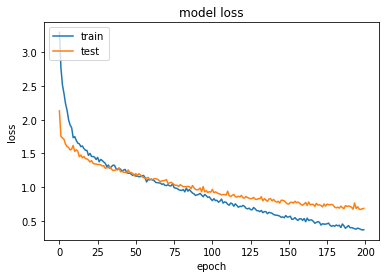

In [64]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

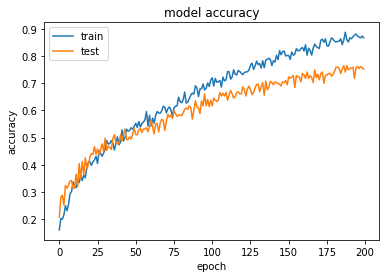

In [65]:

plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [71]:
predictions = np.argmax(model.predict(x_testcnn), axis=-1)

In [69]:
predictions

array([6, 1, 3, 7, 1, 6, 2, 1, 2, 5, 1, 3, 4, 1, 2, 6, 5, 5, 3, 2, 2, 3,
       5, 2, 3, 3, 6, 7, 7, 2, 1, 7, 3, 5, 2, 2, 7, 7, 5, 2, 3, 6, 7, 7,
       7, 1, 7, 3, 3, 6, 2, 5, 3, 2, 1, 7, 2, 1, 5, 5, 4, 3, 5, 4, 3, 3,
       3, 3, 1, 5, 1, 6, 4, 5, 1, 6, 3, 1, 2, 6, 1, 3, 2, 3, 5, 5, 1, 6,
       3, 3, 3, 1, 6, 5, 6, 2, 3, 6, 2, 5, 3, 6, 5, 3, 2, 4, 2, 4, 2, 7,
       2, 1, 7, 7, 7, 5, 3, 3, 5, 6, 5, 2, 4, 5, 2, 1, 5, 2, 3, 5, 3, 5,
       1, 3, 3, 4, 6, 1, 5, 1, 2, 1, 4, 7, 3, 5, 7, 6, 5, 5, 3, 2, 2, 1,
       5, 3, 1, 2, 5, 7, 2, 3, 4, 2, 4, 5, 7, 2, 4, 3, 4, 1, 4, 6, 4, 6,
       7, 5, 7, 2, 1, 2, 5, 7, 2, 1, 3, 4, 1, 6, 7, 2, 2, 7, 5, 1, 3, 7,
       6, 2, 3, 3, 3, 7, 1, 7, 5, 6, 2, 4, 2, 6, 5, 6, 4, 2, 3, 6, 4, 3,
       4, 1, 2, 2, 4, 5, 3, 3, 6, 2, 5, 3, 2, 1, 4, 3, 6, 1, 6, 2, 7, 1,
       4, 5, 6, 3, 1, 2, 3, 2, 2, 2, 4, 2, 5, 6, 4, 4, 7, 5, 1, 2, 6, 2,
       3, 4, 4, 7, 4, 6, 7, 2, 2, 7, 5, 2, 1, 2, 2, 5, 2, 3, 7, 5, 5, 1,
       7, 6, 4, 3, 5, 6, 5, 2, 1, 7, 7, 1, 1, 3, 4,

In [73]:
y_test

,0
694,6
1116,2
58,1
70,5
1030,1
...,...
261,5
1022,1
622,1
339,6


In [74]:

new_Ytest = y_test.astype(int)

In [76]:
from sklearn.metrics import classification_report,confusion_matrix
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           1       0.73      0.85      0.79        52
           2       0.73      0.85      0.79        62
           3       0.74      0.80      0.77        60
           4       0.89      0.66      0.76        59
           5       0.69      0.76      0.72        55
           6       0.83      0.70      0.76        50
           7       0.71      0.60      0.65        48

    accuracy                           0.75       386
   macro avg       0.76      0.75      0.75       386
weighted avg       0.76      0.75      0.75       386



----accuracy score 75.12953367875647 ----


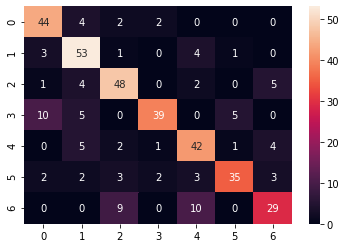

In [80]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

acc = float(accuracy_score(new_Ytest,predictions))*100
print("----accuracy score %s ----" % acc)


cm = confusion_matrix(new_Ytest,predictions)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()